In [ ]:
# default_exp simulation

# Simulation

> Tools for  simulating cellular vertex dynamics. Iterative algorithm implementations, cell monolayer generators (vertices). (anything else to add?!)

- numerical integration method(s)
    - Euler's method
    - any other approximation?
- implement functions for checking:
    - vertex configuration (for high tension cases there might be overlapping, or twisted cells which are considered illigal by the model)
    - update steps that implement required vertex check, and any other checks needed before accepting vertex position update
- implement Voronoi cell generator for different cell configuration cases (random, evenly spaced, concave cell, ...)

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
from vertex_simulation.primitives import *
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import torch, numpy as np, matplotlib.pyplot as plt
from scipy.spatial import Voronoi,voronoi_plot_2d

## Euler's method

In [ ]:
# define function for numerical integration

## Cell Monolayer Graph Generator and Helper functions

In [ ]:
#export
def mask2vrn_region(verts,vrn_regions,row_mask):
    '''Apply mask to Voronoi regions and vertices and re-label them.
    
    In addition to the `row_mask` (for vertices), also removes empty regions
    and regions with "-1" Voronoi vertices.
    
    Arg-s:
    - `verts` : Voronoi vertex locations (`numpy` array).
    - `vrn_regions`: Voronoi regions ("cells"). Empty regions and
    out-of-diagram Voronoi regions with "-1" vertices are removed.
    - `row_mask`: 1-d binary mask for `verts` rows.
    
    Returns:
    - `v_x` : vertices after applying the mask (`=verts[row_mask,:]`)
    - `regions`: re-labelled regions (with updated vertex indices) 
    '''
    v_x = verts[row_mask,:]
    idx_0    = np.arange(verts.shape[0])
    idx_keep = idx_0[row_mask]
    idx_new    = np.arange(idx_keep.shape[0])
    # hexagon regions
    regions = [[idx_new[idx_keep==v].item() for v in r] for r in vrn_regions
               if len(r) and (-1 not in r) and np.all(row_mask[r])]
    return v_x, regions

In [ ]:
#export
def unit_hex_seeds(Sx,Sy):
    '''Produces seed locations for Voronoi such that Voronoi regions 
    form rectangle of hexagonal cells with unit side length (==1).
    
    Arg-s:
    - `Sx`, `Sy`: width (x-axis) and height (y-axis) in cells (assumes that both $S_{x,y}>0$)
    
    Returns:
    - `numpy` array with `Sx`x`Sy` rows and 2 columns.
    '''
    # for regular hexagons with unit length edges
    dXY = [np.sqrt(3), 1.5] # original grid spacing
    x_offset = np.sqrt(3)/2 # moves alter-g rows to the right (+ x-axis)
    X,Y = np.meshgrid(np.linspace(0,(Sx-1)*dXY[0],Sx),np.linspace(0,(Sy-1)*dXY[1],Sy))
    X[1::2,:]+=x_offset
    return np.concatenate((X.ravel()[:,np.newaxis],Y.ravel()[:,np.newaxis]),axis=1)

In [ ]:
# export
def unit_hexagons(Ny,Nx):
    '''Produces Ny rows-by-Nx columns of hexagons with unit length edges.
    
    Uses scipy.spatial.Voronoi, and unit_hex_seeds then trims
    non-hexagon edge cells and vertices.
    
    Returns:
    - `v_x`: vertex locations, Mx2 `numpy` array (M number of vertices)
    - `regions`: cell vertices (Voronoi regions; list of lists)
    '''
    def hex_mask_(verts,Nx,l_tol = 0.0001):
        '''Mask for vertices forming closed hexagons'''
        # mask for removing vertices pentagon region tips (left and right sides)
        mask_hex = np.logical_and(verts[:,0]>0, verts[:,0]<(Nx+1.5)*np.sqrt(3))
        v_x = verts[mask_hex,:]
        # remove corner vertices (not forming hexagons)
        Xmin =(1.+l_tol)*v_x.min(axis=0)
        Xmax =(1.-l_tol)*v_x.max(axis=0)
        left_btm = np.logical_not(np.logical_and(verts[:,0]<Xmin[0],verts[:,1]<Xmin[1]))
        left_top = np.logical_not(np.logical_and(verts[:,0]<Xmin[0],verts[:,1]>Xmax[1]))
        rght_top = np.logical_not(np.logical_and(verts[:,0]>Xmax[0],verts[:,1]>Xmax[1]))
        mask_cor = np.logical_and(np.logical_and(left_btm,left_top),rght_top)
        # full mask
        return np.logical_and(mask_hex,mask_cor)
    
    Xseed = unit_hex_seeds(Nx+2,Ny+2)
    vrn = Voronoi(Xseed)
    vrn_mask = hex_mask_(vrn.vertices,Nx)
    v_x,regions = mask2vrn_region(vrn.vertices,vrn.regions,vrn_mask)
    return v_x,regions

**Notes**:
- `unit_hexagons` internally removes non-hexagon region vertices at the boundaries (left and right) produced by `scipy.spatial.Voronoi`
- If you would like to keep these "raw" vertices, you can use `unit_hex_seeds` to seed `scipy.spatial.Voronoi` directly.

**Usage examples**:

- Generate graph vertices arranged as a lattice of unit length hexagons

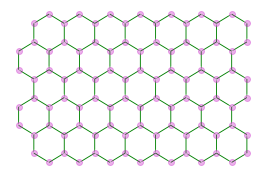

In [ ]:
v_x,regions =unit_hexagons(5,7) # unit hexagon vertices
edge_list,_ = VoronoiRegions2Edges(regions) #get list of edges

# display the graph:
plt.figure(figsize=[4.5,3])
plot_graph_as_quiver(Graph(Vertex(v_x),torch.tensor(edge_list)))
plt.plot(v_x[:,0],v_x[:,1],'mo',alpha=.3)
plt.show()

- Use these vertices and Voronoi regions to generate `Monolayer` objects,
- you can use `VoronoiRegions2Edges` to convert Voronoi regions into an edge list and corresponding cells required for `Monolayer` initialization.

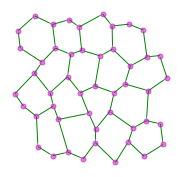

In [ ]:
v_x,regions =unit_hexagons(4,4)

# add some noise
np.random.seed(42) # RNG seed
v_x += np.random.randn(v_x.shape[0], v_x.shape[1])*.2

# get edges and cells (as a set of edges)
edge_list,cells = VoronoiRegions2Edges(regions) 

# create a Monolayer object from the hexagonal cells
cell_graph = Monolayer(vertices=Vertex(v_x.copy()),
                       edges=torch.tensor(edge_list),
                       cells=cells)

figsize=[3,3]
plt.figure(figsize=figsize)
plot_graph_as_quiver(cell_graph)
plt.plot(cell_graph.vertices.x[:,0].detach().cpu(),
         cell_graph.vertices.x[:,1].detach().cpu(),'mo',ms=5,alpha=.5)
plt.show()

In [ ]:
#hide
# run this as a last cell in your notebook to export this module
from nbdev.export import *
notebook2script()

Converted 00_primitives.ipynb.
Converted 01_simulation.ipynb.
Converted index.ipynb.
Converted vertex_dynamics_models.ipynb.
